# IGBP Landcover classification

Open the high resolution dataset and extract the land flags that we need, then
reproject it to the windsat grid (Equal Degrees 0.25x0.25)


In [2]:
import xarray as xr
import numpy as np
import rasterio
import os

### For Windsat dataset

In [70]:
# Load a single windsat file to act as a template for the reprojection
windsat_folder = "../../data/raw/daily_windsat"
wsds = xr.open_dataset(
    os.path.join(windsat_folder, os.listdir(windsat_folder)[0]),
    decode_times = False
)
template = wsds[
    [
        "latitude",
        "longitude",
        "surtep_ERA5",
    ]
]

# Assing coordinates 
template = template.assign_coords(
    {
        "lat" : template.latitude,
        "lon" : template.longitude
    }
)

# roll the longitude 180º
template = template.roll(
    {
        "longitude_grid" : 4 * 180
    }
)

# Rename lat to y and lon to x
template = template.rename(
    {
        "lat": "y",
        "lon" : "x"
    }
)

# Manually add the crs
template.rio.write_crs("epsg:4326", inplace=True)
template = template.swap_dims(
    {
        "latitude_grid": "y",
        "longitude_grid" : "x"
    }
)

template = template.sel(swath_sector = 0)
template

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 720, x: 1440)
Coordinates:
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
    spatial_ref  int32 4B 0
Data variables:
    latitude     (y) float32 3kB ...
    longitude    (x) float32 6kB 180.1 180.4 180.6 180.9 ... 179.4 179.6 179.9
    surtep_ERA5  (y, x) float32 4MB nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

# DATASET
https://lpdaac.usgs.gov/products/mcd12c1v006/

In [71]:
igbp_path = r"..\..\data\raw\MCD12C1.A2012001.051.2013178154403.hdf"
igpb_ds = xr.open_dataset(igbp_path, engine="netcdf4")

# Select the IGBP landcover classification dvar (Majority in each 0.05º pixel)
desired_dv = "Majority_Land_Cover_Type_1"
igpb_ds = igpb_ds.drop_vars(
    dvar for dvar in igpb_ds.data_vars.keys() if dvar != desired_dv
)
igpb_ds


<xarray.Dataset> Size: 104MB
Dimensions:                     (YDim:MOD12C1: 3600, XDim:MOD12C1: 7200)
Dimensions without coordinates: YDim:MOD12C1, XDim:MOD12C1
Data variables:
    Majority_Land_Cover_Type_1  (YDim:MOD12C1, XDim:MOD12C1) float32 104MB ...
Attributes:
    HDFEOSVersion:      HDFEOS_V2.9
    StructMetadata.0:   GROUP=SwathStructure\nEND_GROUP=SwathStructure\nGROUP...
    CoreMetadata.0:     \nGROUP                  = INVENTORYMETADATA\n  GROUP...
    ArchiveMetadata.0:  \nGROUP                  = ARCHIVEDMETADATA\n  GROUPT...

Sadly the product does not include the latitude and longitude coordinates, but we can generate them knowing the metadata and add them as coordinate vectors for latitude and longitude


In [72]:
gridSize = 0.05 #degrees
# We want the location of the center for each pixel
lat = np.arange(-90 + (gridSize / 2), 90 - (gridSize / 2) + gridSize, gridSize)
lon = np.arange(-180 + (gridSize / 2), 180 - (gridSize / 2) + gridSize, gridSize).tolist()

# Change lon origin to be 0 to 360
lon = [(l + 180) % 360 for l in lon]

lat = lat[::-1] # I needed to flip latitude as well ... 

# Add them as coordinates
igpb_ds = igpb_ds.assign_coords({
    "y" : ("YDim:MOD12C1",lat), 
    "x" : ("XDim:MOD12C1",lon),
})

# Reverse the latitude
igpb_ds = igpb_ds.isel(
    {
        "YDim:MOD12C1":slice(None, None, -1)
    }
)

igpb_ds.rio.write_crs("epsg:4326", inplace=True)
igpb_ds.attrs = {} #The metadata is anoying for notebook visualization

#Rioxarray needs the dimentions to be called "x" and "y" ... 
igpb_ds = igpb_ds.swap_dims({
    "YDim:MOD12C1" : "y",
    "XDim:MOD12C1" : "x"
})
igpb_ds

<xarray.Dataset> Size: 104MB
Dimensions:                     (y: 3600, x: 7200)
Coordinates:
  * y                           (y) float64 29kB -89.97 -89.92 ... 89.92 89.97
  * x                           (x) float64 58kB 0.025 0.075 ... 359.9 360.0
    spatial_ref                 int32 4B 0
Data variables:
    Majority_Land_Cover_Type_1  (y, x) float32 104MB ...

---

Reproject using the mode for each cell of the windsat grid

In [73]:
igbp_wsgrid = igpb_ds.Majority_Land_Cover_Type_1.rio.reproject_match(template.surtep_ERA5,rasterio.enums.Resampling.mode)
igbp_wsgrid

<xarray.DataArray 'Majority_Land_Cover_Type_1' (y: 720, x: 1440)> Size: 4MB
array([[12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
    spatial_ref  int32 4B 0
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Attributes: (12/21)
    long_name:                           Majority_Land_Cover_Type_1
    units:                               class number
    valid_range:                         [ 0 16]
    water:                               0
    evergreen needleleaf forest:         1
    evergreen broadleaf forest:          2
    ...                                  ...
    croplands:                           12
    urban and built-up:                  13
    cropland/natural vegetation mosaic:  14
    snow and ice:                        15
    barren or sparsely vegetated:        16
    unclassified:                        255

In [74]:
#I decided to save this DataArray into the template
template["IGBP"] = igbp_wsgrid

# Get the single variable Dataset to save as hdf5
igbp_wsgrid = template.drop_vars([
    dv for dv in template.data_vars if dv != "IGBP"
])
igbp_wsgrid

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 720, x: 1440)
Coordinates:
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
    spatial_ref  int32 4B 0
Data variables:
    IGBP         (y, x) float32 4MB 12.0 12.0 12.0 12.0 12.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [75]:
# Save the file
save_path = os.path.join(r"..\\..\\data\processed\\", "regridded.h5")
igbp_wsgrid.to_netcdf(save_path, engine="h5netcdf")

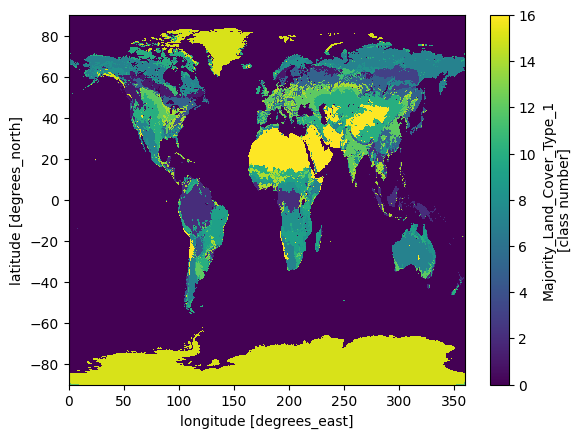

In [76]:
# Load the Landcover classification
xr.open_dataset(save_path).IGBP.plot()

In [82]:
igbp_wsgrid.IGBP.values

array([[12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.],
       [12., 12., 12., ..., 12., 12., 12.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

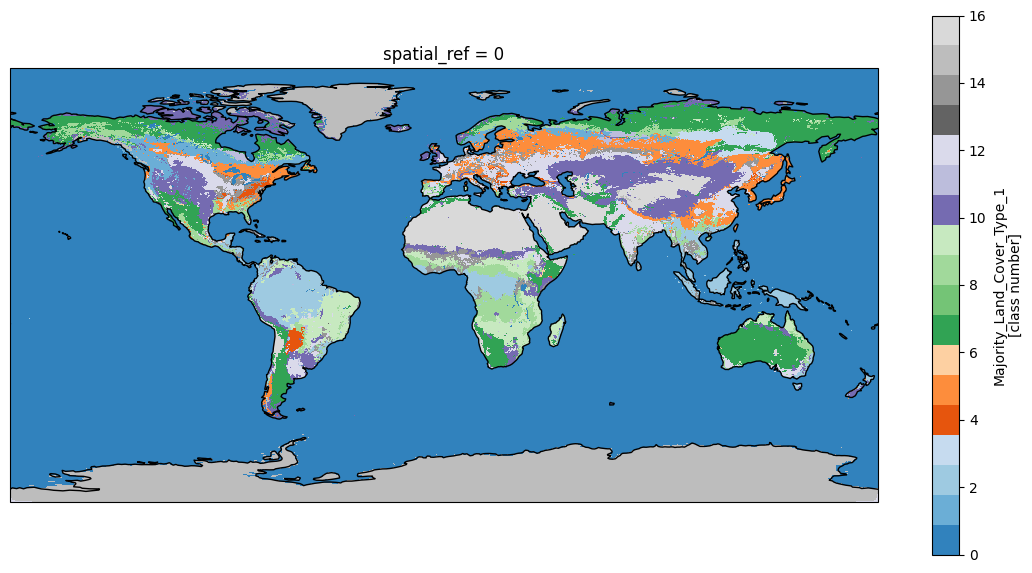

In [91]:
# Try plotting a coastline on top of the data
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.colormaps.get_cmap("tab20c").resampled(18)

fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw = {"projection" : ccrs.PlateCarree(central_longitude=0)})


igbp_wsgrid.roll(
    {
        "x" : 180 * 4
    }
).IGBP.plot(ax= ax, cmap = cmap)

ax.coastlines("110m")

In [90]:
igbp_wsgrid.IGBP.attrs

{'long_name': 'Majority_Land_Cover_Type_1',
 'units': 'class number',
 'valid_range': array([ 0, 16], dtype=uint8),
 'water': 0,
 'evergreen needleleaf forest': 1,
 'evergreen broadleaf forest': 2,
 'deciduous needleleaf forest': 3,
 'deciduous broadleaf forest': 4,
 'mixed forests': 5,
 'closed shrubland': 6,
 'open shrublands': 7,
 'woody savannas': 8,
 'savannas': 9,
 'grasslands': 10,
 'permanent wetlands': 11,
 'croplands': 12,
 'urban and built-up': 13,
 'cropland/natural vegetation mosaic': 14,
 'snow and ice': 15,
 'barren or sparsely vegetated': 16,
 'unclassified': 255}

--- 

## For AMSR2 data

In [13]:
# Load a single windsat file to act as a template for the reprojection
amsr2_folder = r"../..\data\raw\ka_36ghz\Ascending"
amsrds = xr.open_dataset(
    os.path.join(amsr2_folder, os.listdir(amsr2_folder)[0]),
    decode_times = False
)
amsrds


<xarray.Dataset> Size: 10MB
Dimensions:                     (lon: 1388, lat: 584)
Coordinates:
  * lon                         (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * lat                         (lat) float32 2kB -83.52 -81.98 ... 81.98 83.52
Data variables:
    Brightness Temperature (H)  (lat, lon) float32 3MB ...
    Brightness Temperature (V)  (lat, lon) float32 3MB ...
    Time Information            (lat, lon) float32 3MB ...
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

In [18]:
# Select a dummy datavar.
template = amsrds[
    [
        "lon",
        "lat",
        "Brightness Temperature (V)",
    ]
]

# longitude must be 0 to 360
new_lon = [(180 +v) % 360 for v in template.lon.values]
template["lon"] = new_lon

template


<xarray.Dataset> Size: 3MB
Dimensions:                     (lon: 1388, lat: 584)
Coordinates:
  * lon                         (lon) float64 11kB 0.1297 0.3891 ... 359.6 359.9
  * lat                         (lat) float32 2kB -83.52 -81.98 ... 81.98 83.52
Data variables:
    Brightness Temperature (V)  (lat, lon) float32 3MB ...
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

In [19]:
# Rename lat to y and lon to x
template = template.rename(
    {
        "lat": "y",
        "lon" : "x"
    }
)
template

<xarray.Dataset> Size: 3MB
Dimensions:                     (x: 1388, y: 584)
Coordinates:
  * x                           (x) float64 11kB 0.1297 0.3891 ... 359.6 359.9
  * y                           (y) float32 2kB -83.52 -81.98 ... 81.98 83.52
Data variables:
    Brightness Temperature (V)  (y, x) float32 3MB ...
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

In [21]:
# Manually add the crs
template.rio.write_crs("epsg:4326", inplace=True)
template

<xarray.Dataset> Size: 3MB
Dimensions:                     (x: 1388, y: 584)
Coordinates:
  * x                           (x) float64 11kB 0.1297 0.3891 ... 359.6 359.9
  * y                           (y) float32 2kB -83.52 -81.98 ... 81.98 83.52
    spatial_ref                 int32 4B 0
Data variables:
    Brightness Temperature (V)  (y, x) float32 3MB ...
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

In [23]:
igbp_amsrgrid = igpb_ds.Majority_Land_Cover_Type_1.rio.reproject_match(template["Brightness Temperature (V)"],rasterio.enums.Resampling.mode)
igbp_amsrgrid

<xarray.DataArray 'Majority_Land_Cover_Type_1' (y: 584, x: 1388)> Size: 3MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    spatial_ref  int32 4B 0
  * x            (x) float64 11kB 0.1297 0.3891 0.6484 ... 359.4 359.6 359.9
  * y            (y) float32 2kB -83.52 -81.98 -80.7 -79.57 ... 80.7 81.98 83.52
Attributes: (12/21)
    long_name:                           Majority_Land_Cover_Type_1
    units:                               class number
    valid_range:                         [ 0 16]
    water:                               0
    evergreen needleleaf forest:         1
    evergreen broadleaf forest:          2
    ...                                  ...
    croplands:                           12
    urban and built-up:                  13
    cropland/natural vegetation mosaic:  14
    snow and ice:                        15
    barren or sparsely vegetated:        16
    unclassified:                        255

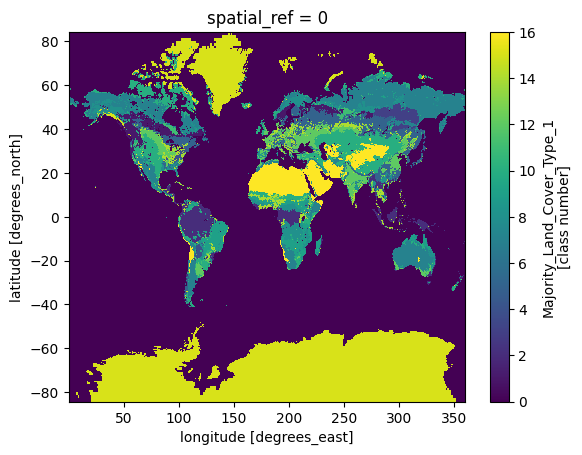

In [24]:
igbp_amsrgrid.plot()

In [25]:
# Save it into a .h5 file.

# Save the file
save_path = os.path.join(r"..\\..\\data\processed\\", "AMSR2_IGPB.h5")
igbp_amsrgrid.to_netcdf(save_path, engine="h5netcdf")

<xarray.Dataset> Size: 3MB
Dimensions:                     (x: 1388, y: 584)
Coordinates:
  * x                           (x) float64 11kB 0.1297 0.3891 ... 359.6 359.9
  * y                           (y) float32 2kB -83.52 -81.98 ... 81.98 83.52
Data variables:
    spatial_ref                 int32 4B ...
    Majority_Land_Cover_Type_1  (y, x) float32 3MB ...

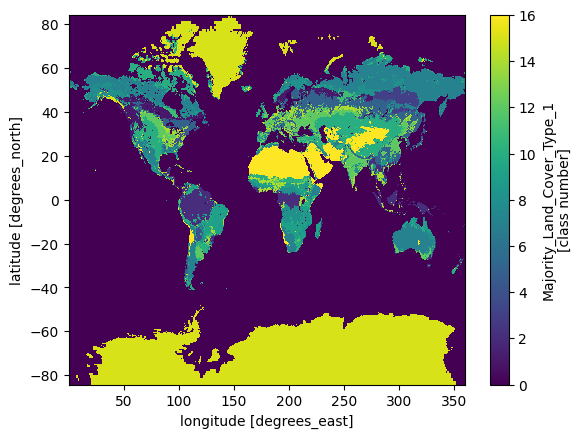

In [30]:
sds = xr.open_dataset(save_path)
sds.Majority_Land_Cover_Type_1.plot()
sds

--- 

Get the Heterogeneity of the pixels

$GSI = 1 - \Sigma p_i^2$

using the IGBP 

In [1]:
import xarray as xr
import numpy as np
import dask.array as da
import rasterio
import os

igbp_path = r"..\..\data\raw\MCD12C1.A2012001.051.2013178154403.hdf"
igbp_ds = xr.open_dataset(igbp_path, engine="netcdf4")
igbp_ds.rio.write_crs("epsg:4326", inplace=True)
igbp_ds.attrs = {} # Attrs are too long, delet them 
igbp_ds

<xarray.Dataset> Size: 5GB
Dimensions:                                (YDim:MOD12C1: 3600,
                                            XDim:MOD12C1: 7200,
                                            Num_IGBP_Classes:MOD12C1: 18,
                                            Num_UMD_Classes:MOD12C1: 15,
                                            Num_LAI_FPAR_Classes:MOD12C1: 12)
Coordinates:
    spatial_ref                            int32 4B 0
Dimensions without coordinates: YDim:MOD12C1, XDim:MOD12C1,
                                Num_IGBP_Classes:MOD12C1,
                                Num_UMD_Classes:MOD12C1,
                                Num_LAI_FPAR_Classes:MOD12C1
Data variables:
    Majority_Land_Cover_Type_1             (YDim:MOD12C1, XDim:MOD12C1) float32 104MB ...
    Majority_Land_Cover_Type_1_Assessment  (YDim:MOD12C1, XDim:MOD12C1) float32 104MB ...
    Land_Cover_Type_1_Percent              (YDim:MOD12C1, XDim:MOD12C1, Num_IGBP_Classes:MOD12C1) float32 2GB ...
    Majority_Land_Cover_Type_1_QC          (YDim:MOD12C1, XDim:MOD12C1) float32 104MB ...
    Majority_Land_Cover_Type_2             (YDim:MOD12C1, XDim:MOD12C1) float32 104MB ...
    Majority_Land_Cover_Type_2_Assessment  (YDim:MOD12C1, XDim:MOD12C1) float32 104MB ...
    Land_Cover_Type_2_Percent              (YDim:MOD12C1, XDim:MOD12C1, Num_UMD_Classes:MOD12C1) float32 2GB ...
    Majority_Land_Cover_Type_3             (YDim:MOD12C1, XDim:MOD12C1) float32 104MB ...
    Majority_Land_Cover_Type_3_Assessment  (YDim:MOD12C1, XDim:MOD12C1) float32 104MB ...
    Land_Cover_Type_3_Percent              (YDim:MOD12C1, XDim:MOD12C1, Num_LAI_FPAR_Classes:MOD12C1) float32 1GB ...

In [2]:
# Load a single windsat file to act as a template for the reprojection
windsat_folder = "../../data/raw/daily_windsat"
wsds = xr.open_dataset(
    os.path.join(windsat_folder, os.listdir(windsat_folder)[0]),
    decode_times = False
)
template = wsds[
    [
        "latitude",
        "longitude",
        "surtep_ERA5",
    ]
]

# Assing coordinates 
template = template.assign_coords(
    {
        "lat" : template.latitude,
        "lon" : template.longitude
    }
)

# roll the longitude 180º
template = template.roll(
    {
        "longitude_grid" : 4 * 180
    }
)

# Rename lat to y and lon to x
template = template.rename(
    {
        "lat": "y",
        "lon" : "x"
    }
)

# Manually add the crs
template.rio.write_crs("epsg:4326", inplace=True)
template = template.swap_dims(
    {
        "latitude_grid": "y",
        "longitude_grid" : "x"
    }
)

template = template.sel(swath_sector = 0)
del wsds
template

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 720, x: 1440)
Coordinates:
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
    spatial_ref  int32 4B 0
Data variables:
    latitude     (y) float32 3kB ...
    longitude    (x) float32 6kB 180.1 180.4 180.6 180.9 ... 179.4 179.6 179.9
    surtep_ERA5  (y, x) float32 4MB nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [3]:
gridSize = 0.05 #degrees
# We want the location of the center for each pixel
lat = np.arange(-90 + (gridSize / 2), 90 - (gridSize / 2) + gridSize, gridSize)
lon = np.arange(-180 + (gridSize / 2), 180 - (gridSize / 2) + gridSize, gridSize).tolist()

# Change lon origin to be 0 to 360
lon = [(l + 180) % 360 for l in lon]

lat = lat[::-1] # I needed to flip latitude as well ... 

# Add them as coordinates
igbp_ds = igbp_ds.assign_coords({
    "y" : ("YDim:MOD12C1",lat), 
    "x" : ("XDim:MOD12C1",lon),
})

# Reverse the latitude
igbp_ds = igbp_ds.isel(
    {
        "YDim:MOD12C1":slice(None, None, -1)
    }
)

igbp_ds.rio.write_crs("epsg:4326", inplace=True)
igbp_ds.attrs = {} #The metadata is anoying for notebook visualization

#Rioxarray needs the dimentions to be called "x" and "y" ... 
igbp_ds = igbp_ds.swap_dims({
    "YDim:MOD12C1" : "y",
    "XDim:MOD12C1" : "x"
})
del lat
del lon
igbp_ds

<xarray.Dataset> Size: 5GB
Dimensions:                                (y: 3600, x: 7200,
                                            Num_IGBP_Classes:MOD12C1: 18,
                                            Num_UMD_Classes:MOD12C1: 15,
                                            Num_LAI_FPAR_Classes:MOD12C1: 12)
Coordinates:
  * y                                      (y) float64 29kB -89.97 ... 89.97
  * x                                      (x) float64 58kB 0.025 ... 360.0
    spatial_ref                            int32 4B 0
Dimensions without coordinates: Num_IGBP_Classes:MOD12C1,
                                Num_UMD_Classes:MOD12C1,
                                Num_LAI_FPAR_Classes:MOD12C1
Data variables:
    Majority_Land_Cover_Type_1             (y, x) float32 104MB ...
    Majority_Land_Cover_Type_1_Assessment  (y, x) float32 104MB ...
    Land_Cover_Type_1_Percent              (y, x, Num_IGBP_Classes:MOD12C1) float32 2GB ...
    Majority_Land_Cover_Type_1_QC          (y, x) float32 104MB ...
    Majority_Land_Cover_Type_2             (y, x) float32 104MB ...
    Majority_Land_Cover_Type_2_Assessment  (y, x) float32 104MB ...
    Land_Cover_Type_2_Percent              (y, x, Num_UMD_Classes:MOD12C1) float32 2GB ...
    Majority_Land_Cover_Type_3             (y, x) float32 104MB ...
    Majority_Land_Cover_Type_3_Assessment  (y, x) float32 104MB ...
    Land_Cover_Type_3_Percent              (y, x, Num_LAI_FPAR_Classes:MOD12C1) float32 1GB ...

--- 

## THIS TAKES 10 minutes and ~3GB RAM

In [4]:
# I Need chunking for this operation
# Select and transpose the datavar 
igbp_percent = igbp_ds.Land_Cover_Type_1_Percent.transpose('Num_IGBP_Classes:MOD12C1', 'y', 'x')


# Define a function to reproject each layer
def reproject_layer(layer):
    return layer.rio.reproject_match(template.surtep_ERA5, rasterio.enums.Resampling.average)

# Apply the reprojection to each layer individually and collect results
reprojected_layers = []
for i in range(igbp_percent.shape[0]):
    layer = igbp_percent.isel(
        {'Num_IGBP_Classes:MOD12C1': i}
    )
    reprojected_layer = reproject_layer(layer)
    reprojected_layers.append(reprojected_layer)

# Combine reprojected layers into a single 3D array
igbp_percent__wsgrid = xr.concat(reprojected_layers, dim='Num_IGBP_Classes:MOD12C1')

# Optionally, persist the data to ensure all computations are completed
igbp_percent__wsgrid = igbp_percent__wsgrid.persist()

igbp_percent__wsgrid

<xarray.DataArray 'Land_Cover_Type_1_Percent' (Num_IGBP_Classes:MOD12C1: 18,
                                               y: 720, x: 1440)> Size: 75MB
array([[[  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        ...,
        [100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
        [100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
        [100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ]],

       [[  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        ...,
...
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]]],
      dtype=float32)
Coordinates:
    spatial_ref  int32 4B 0
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Dimensions without coordinates: Num_IGBP_Classes:MOD12C1
Attributes: (12/21)
    long_name:    Land_Cover_Type_1_Percent
    units:        percent in integers
    valid_range:  [  0 100]
    Layer 0:      water
    Layer 1:      evergreen needleleaf forest
    Layer 2:      evergreen broadleaf forest
    ...           ...
    Layer 12:     croplands
    Layer 13:     urban and built-up
    Layer 14:     cropland/natural vegetation mosaic
    Layer 15:     snow and ice
    Layer 16:     barren or sparsely vegetated
    Layer 17:     unclassified + fill values

In [5]:
# Save the results:
igbp_percent__wsgrid.to_netcdf('../../data/processed/reprojected_igbp_percent_wsgrid.h5')


In [6]:
# Calculate the index
# Convert percentage values to probabilities
probabilities = igbp_percent__wsgrid / 100.0

# Check if the sum of probabilities is 1 for each pixel
total_probabilities = probabilities.sum(dim='Num_IGBP_Classes:MOD12C1')
assert np.allclose(total_probabilities, 1.0), "Sum of probabilities for each pixel must equal 1."

# Calculate GSI for each pixel
GSI_i = 1 - np.sum(probabilities**2, axis=0)

# Convert GSI_i to xarray DataArray for convenience
GSI_dataarray = xr.DataArray(GSI_i, dims=('y', 'x'))

# Optionally, assign attributes or coordinates if needed
GSI_dataarray.attrs.update({
    'long_name': 'Gini-Simpson Index',
    'units': 'dimensionless',
    'description': 'Index describing diversity or dominance of land cover types'
})

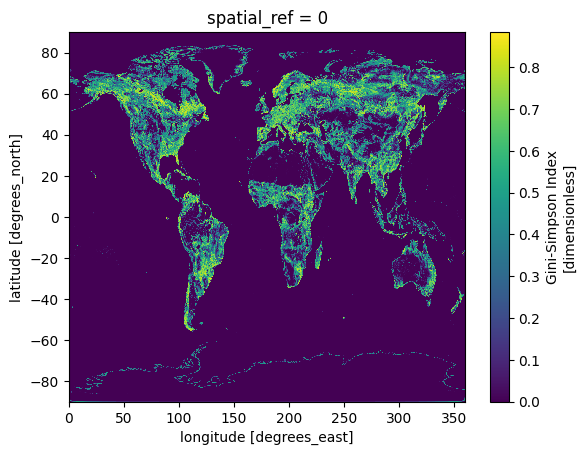

In [8]:
GSI_dataarray.plot()

In [9]:
# Save the index as a separated file
GSI_dataarray.to_netcdf("../../data/processed/igbp_GSI_wsgrid.h5")

In [10]:
GSI_dataarray

<xarray.DataArray 'Land_Cover_Type_1_Percent' (y: 720, x: 1440)> Size: 4MB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07606375, ..., 0.07606375, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
Coordinates:
    spatial_ref  int32 4B 0
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Attributes:
    long_name:    Gini-Simpson Index
    units:        dimensionless
    description:  Index describing diversity or dominance of land cover types